Epoch [1/2] - Loss: 0.3273
Epoch [2/2] - Loss: 0.2979
Accuracy on adversarial examples: 5.47%
Average confidence on wrong predictions: 98.62%


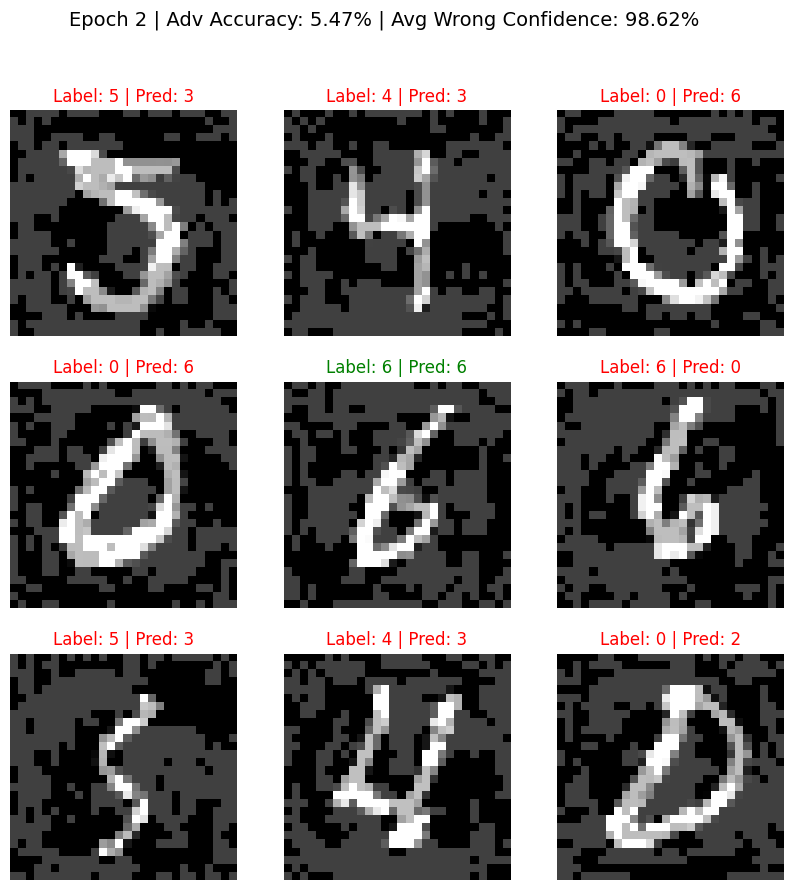

In [3]:
# ============================================================
# Maxout Network + FGSM Attack (MNIST)
# Epsilon = 0.25 | Optimizer = Adam
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# ============================================================
# Configuration globale
# ============================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOSS_FN = nn.CrossEntropyLoss()

# ============================================================
# FGSM Attack
# ============================================================

def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)
    images.requires_grad = True

    outputs = model(images)
    loss = LOSS_FN(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adv_images = torch.clamp(images + perturbation, 0, 1)

    return adv_images.detach()

# ============================================================
# Maxout Layers & Network
# ============================================================

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super().__init__()
        self.out_features = out_features
        self.num_pieces = num_pieces
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), self.out_features, self.num_pieces)
        return x.max(dim=2)[0]


class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super().__init__()
        self.layer1 = Maxout(28 * 28, 128, num_pieces)
        self.layer2 = Maxout(128, 10, num_pieces)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

# ============================================================
# Data Loading
# ============================================================

def load_mnist(batch_size=64):
    transform = transforms.ToTensor()
    dataset = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ============================================================
# Training
# ============================================================

def train(model, dataloader, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {avg_loss:.4f}")

# ============================================================
# Adversarial Evaluation
# ============================================================

def evaluate_adversarial(model, dataloader, epsilon):
    model.eval()
    correct = 0
    total = 0
    incorrect_confidences = []

    with torch.no_grad():
        pass  # Needed only to keep structure clear

    for images, labels in dataloader:
        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        labels = labels.to(DEVICE)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        for i in range(labels.size(0)):
            if preds[i] != labels[i]:
                incorrect_confidences.append(probs[i, preds[i]].item())

    accuracy = 100 * correct / total
    avg_conf = 100 * np.mean(incorrect_confidences) if incorrect_confidences else 0

    print(f"Accuracy on adversarial examples: {accuracy:.2f}%")
    print(f"Average confidence on wrong predictions: {avg_conf:.2f}%")

    return accuracy, avg_conf

# ============================================================
# Visualization
# ============================================================

def plot_adversarial_examples(images, labels, preds, accuracy, epoch, avg_conf):
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        color = "green" if labels[i] == preds[i] else "red"
        plt.title(f"Label: {labels[i]} | Pred: {preds[i]}", color=color)
        plt.axis("off")

    plt.suptitle(
        f"Epoch {epoch} | Adv Accuracy: {accuracy:.2f}% | "
        f"Avg Wrong Confidence: {avg_conf:.2f}%",
        fontsize=14
    )
    plt.show()

# ============================================================
# Main
# ============================================================

def main():
    epsilon = 0.25
    epochs = 2

    train_loader = load_mnist()

    model = MaxoutNN(num_pieces=2).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train(model, train_loader, optimizer, epochs)

    accuracy, avg_conf = evaluate_adversarial(
        model, train_loader, epsilon
    )

    images, labels = next(iter(train_loader))
    adv_images = fgsm_attack(model, images, labels, epsilon)
    outputs = model(adv_images)
    preds = outputs.argmax(dim=1)

    plot_adversarial_examples(
        adv_images, labels, preds, accuracy, epochs, avg_conf
    )

# ============================================================
# Entry Point
# ============================================================

if __name__ == "__main__":
    main()


Epoch [1/15] - Loss: 0.2469
Epoch [2/15] - Loss: 0.1033
Epoch [3/15] - Loss: 0.0824
Epoch [4/15] - Loss: 0.0725
Epoch [5/15] - Loss: 0.0655
Epoch [6/15] - Loss: 0.0610
Epoch [7/15] - Loss: 0.0577
Epoch [8/15] - Loss: 0.0560
Epoch [9/15] - Loss: 0.0533
Epoch [10/15] - Loss: 0.0527
Epoch [11/15] - Loss: 0.0535
Epoch [12/15] - Loss: 0.0506
Epoch [13/15] - Loss: 0.0510
Epoch [14/15] - Loss: 0.0496
Epoch [15/15] - Loss: 0.0522
Accuracy on adversarial examples: 0.43%
Average confidence on wrong predictions: 87.29%


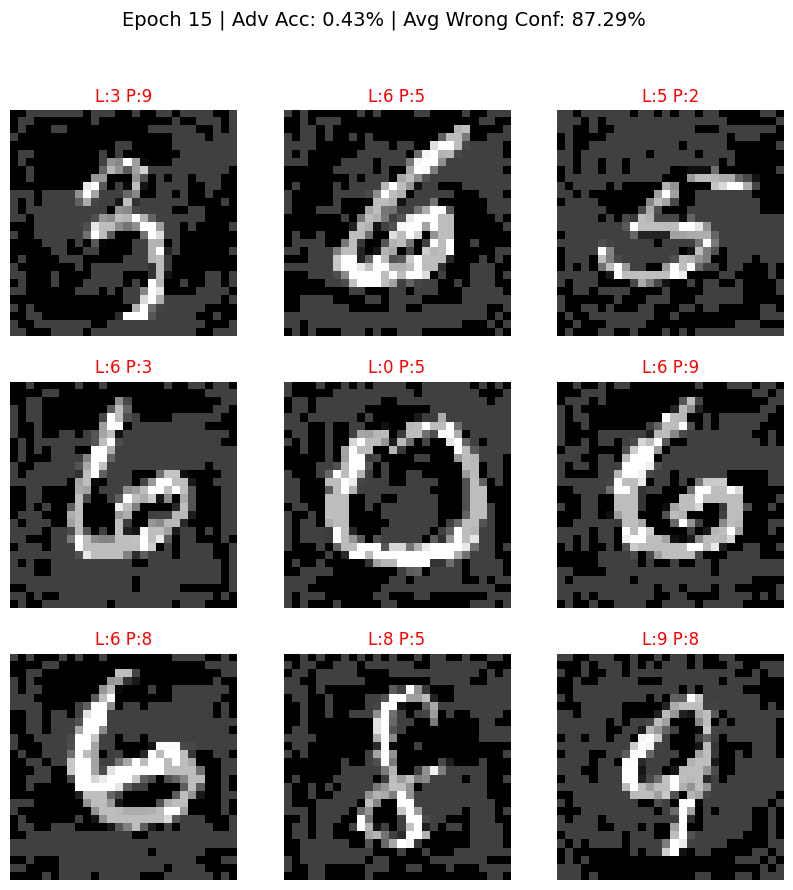

In [5]:
# ============================================================
# Maxout Network + FGSM Attack (MNIST)
# Optimizer = SGD
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

# ============================================================
# Configuration
# ============================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOSS_FN = nn.CrossEntropyLoss()

# ============================================================
# FGSM Attack
# ============================================================

def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)
    images.requires_grad = True

    outputs = model(images)
    loss = LOSS_FN(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adv_images = torch.clamp(images + perturbation, 0, 1)

    return adv_images.detach()

# ============================================================
# Maxout Layers & Network
# ============================================================

class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super().__init__()
        self.out_features = out_features
        self.num_pieces = num_pieces
        self.linear = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), self.out_features, self.num_pieces)
        return x.max(dim=2)[0]


class MaxoutNN(nn.Module):
    def __init__(self, num_pieces=2):
        super().__init__()
        self.layer1 = Maxout(28 * 28, 128, num_pieces)
        self.layer2 = Maxout(128, 10, num_pieces)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

# ============================================================
# Data
# ============================================================

def load_mnist(batch_size=64):
    transform = transforms.ToTensor()
    dataset = torchvision.datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ============================================================
# Training
# ============================================================

def train(model, dataloader, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(
            f"Epoch [{epoch + 1}/{epochs}] "
            f"- Loss: {total_loss / len(dataloader):.4f}"
        )

# ============================================================
# Adversarial Evaluation
# ============================================================

def evaluate_adversarial(model, dataloader, epsilon):
    model.eval()
    correct, total = 0, 0
    incorrect_confidences = []

    for images, labels in dataloader:
        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        labels = labels.to(DEVICE)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        for i in range(labels.size(0)):
            if preds[i] != labels[i]:
                incorrect_confidences.append(probs[i, preds[i]].item())

    accuracy = 100 * correct / total
    avg_conf = 100 * np.mean(incorrect_confidences) if incorrect_confidences else 0

    print(f"Accuracy on adversarial examples: {accuracy:.2f}%")
    print(f"Average confidence on wrong predictions: {avg_conf:.2f}%")

    return accuracy, avg_conf

# ============================================================
# Visualization
# ============================================================

def plot_adversarial_examples(images, labels, preds, accuracy, epoch, avg_conf):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap="gray")
        color = "green" if labels[i] == preds[i] else "red"
        plt.title(f"L:{labels[i]} P:{preds[i]}", color=color)
        plt.axis("off")

    plt.suptitle(
        f"Epoch {epoch} | Adv Acc: {accuracy:.2f}% | "
        f"Avg Wrong Conf: {avg_conf:.2f}%",
        fontsize=14
    )
    plt.show()

# ============================================================
# Main
# ============================================================

def main():
    epsilon = 0.25
    epochs = 15

    train_loader = load_mnist()

    model = MaxoutNN(num_pieces=2).to(DEVICE)

    # 🔥 Optimizer SGD
    optimizer = optim.SGD(
        model.parameters(),
        lr=0.05,
        momentum=0.9,
        weight_decay=5e-4
    )

    train(model, train_loader, optimizer, epochs)

    accuracy, avg_conf = evaluate_adversarial(
        model, train_loader, epsilon
    )

    images, labels = next(iter(train_loader))
    adv_images = fgsm_attack(model, images, labels, epsilon)
    preds = model(adv_images).argmax(dim=1)

    plot_adversarial_examples(
        adv_images, labels, preds, accuracy, epochs, avg_conf
    )

# ============================================================
# Entry Point
# ============================================================

if __name__ == "__main__":
    main()
